In [13]:
len(sentences)

373312

In [14]:
len(next_words)

11666

Running for model: LSTM_40_1_64
Epoch 1/10
37/37 [==============================] - 3s 80ms/step - loss: 2.8929 - val_loss: 2.5597
Epoch 2/10
37/37 [==============================] - 1s 15ms/step - loss: 1.9810 - val_loss: 2.4526
Epoch 3/10
37/37 [==============================] - 1s 14ms/step - loss: 1.4254 - val_loss: 2.6425
Epoch 4/10
37/37 [==============================] - 1s 14ms/step - loss: 1.0221 - val_loss: 2.9550
Epoch 5/10
37/37 [==============================] - 1s 14ms/step - loss: 0.7241 - val_loss: 3.3321
Epoch 6/10
37/37 [==============================] - 1s 14ms/step - loss: 0.5109 - val_loss: 3.6921
Epoch 7/10
37/37 [==============================] - 1s 15ms/step - loss: 0.3806 - val_loss: 4.0902
Epoch 8/10
37/37 [==============================] - 1s 14ms/step - loss: 0.3130 - val_loss: 4.2656
Epoch 9/10
37/37 [==============================] - 1s 14ms/step - loss: 0.2505 - val_loss: 4.3482
Epoch 10/10
37/37 [==============================] - 1s 14ms/step - loss: 0.1

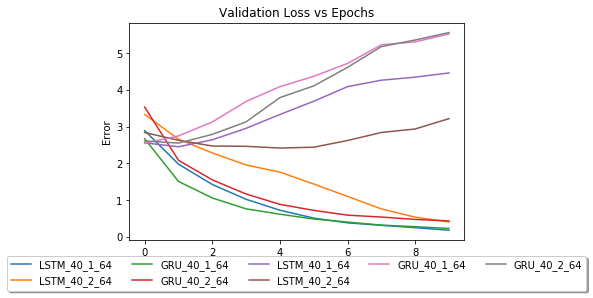

In [18]:
#!/usr/bin/env python
# coding: utf-8

# # Project Name: Lyric Generator
# Description:
# Implementing a Deep Neural network using LSTMs to create a character based lyric generator


import keras
import tensorflow as tf
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Activation, LSTM, Dense, CuDNNLSTM, Flatten, Bidirectional, Dropout, CuDNNGRU
from keras.optimizers import Adam
import pandas as pd
import numpy as np
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
import os
import matplotlib.pyplot as plt
import re
np.random.seed(10)


def load_lyrics(path):
    '''
    Function to load lyrics of all the artists in the input path
    '''
    lyrics = ""
    for fn in os.listdir(path):
        with open(os.path.join(path, fn), 'r') as song:
            song_lyrics = clean_string(song.read())
            lyrics += song_lyrics
    return lyrics


def clean_string(string):
    """
    Cleans unwanted characters and words from string.
    @param string: The string to be cleaned.
    @return: The cleaned string.
    """
    string = string.lower()  # lowercase

    clean_words = []
    for word in string.split():
        if word[0] == '"' and word[-1] != '"':
            word = word[1:]
        elif word[-1] == '"' and word[0] != '"':
            word = word[-1]

        # clean words with parenthases on only one side
        if word[0] == '(' and word[-1] != ')':
            word = word[1:]
        elif word[-1] == ')' and word[0] != '(':
            word = word[:-1]

        clean_words.append(word)
    return ' '.join(clean_words)


def generator(sentence_list, next_word_list, batch_size):
    '''
    Generator function to generate the input/output data using
    generators concept(to avoid RAM overflow)
    '''
    index = 0
    while True:
        x = np.zeros((batch_size, maxlen, vocab_size), dtype=np.bool)
        y = np.zeros((batch_size, vocab_size), dtype=np.bool)
        for i in range(batch_size):
            for t, w in enumerate(sentence_list[index]):
                x[i, t, word_ix[w]] = 1
            y[i, word_ix[next_word_list[index]]] = 1

            index = index + 1
            if index == len(sentence_list):
                index = 0
        yield x, y


def create_LSTM(timesteps, vocab_size, no_layers=2, dropout=0.2):
    '''
    Creating the model
    '''
    model = Sequential()
    for i in range(no_layers):
        model.add(Bidirectional(CuDNNLSTM(128, return_sequences=True),
                                input_shape=(timesteps, vocab_size)))
    model.add(Flatten())
#     model.add(Bidirectional(CuDNNLSTM(128), input_shape=(timesteps,vocab_size)))
    model.add(Dropout(dropout))
    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
#     model.summary()
    model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy')
    return model

def create_GRU(timesteps, vocab_size, no_layers=2, dropout=0.2):
    '''
    Creating the model
    '''
    model = Sequential()
    for i in range(no_layers):
        model.add(Bidirectional(CuDNNGRU(128, return_sequences=True),
                                input_shape=(timesteps, vocab_size)))
    model.add(Flatten())
#     model.add(Bidirectional(CuDNNLSTM(128), input_shape=(timesteps,vocab_size)))
    model.add(Dropout(dropout))
    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
#     model.summary()
    model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy')
    return model


def sample(preds, temperature=1.0):
    '''
    helper function to sample an index from a probability array
    '''
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, logs):
    '''
    Callback function to write output to file after each epoch
    '''
    # Function invoked at end of each epoch. Prints generated text.
    examples_file.write('\n----- Generating text after Epoch: %d\n' % epoch)

    # Randomly pick a seed sequence
    seed_index = np.random.randint(len(sentences+sentences_test))
    seed = (sentences+sentences_test)[seed_index]
    for diversity in [0.3, 0.4, 0.5, 0.6, 0.7]:
        sentence = seed
        examples_file.write('----- Diversity:' + str(diversity) + '\n')
        examples_file.write(
            '----- Generating with seed:\n"' + ''.join(sentence) + '"\n')
        examples_file.write("----- Generated lyrics:\n")
        examples_file.write(''.join(sentence))

        for i in range(100):
            x_pred = np.zeros((1, maxlen, vocab_size))
            for t, word in enumerate(sentence):
                x_pred[0, t,word_ix[word]] = 1

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char_pred = ix_word[next_index]

            sentence = sentence[1:]
#             print(sentence)
            sentence += next_char_pred

            examples_file.write(next_char_pred)
        examples_file.write('\n\n')
    examples_file.write('='*80 + '\n')

BATCH_SIZE = 256
epochs = 10
song_count = 10


# Reading the kaggle input ~55k songs
df = pd.read_csv('../songdata.csv')['text'][:song_count]
data = np.array(df)

corpus=''
for ix in range(len(data)):
    corpus+=data[ix]
corpus = corpus.lower()
corpus = clean_string(corpus)
# print('Corpus length in words:', len(corpus))

vocab = set(corpus)
# ### Creating Vocabulary and char, index mappings
word_ix = {c: i for i, c in enumerate(vocab)}
ix_word = {i: c for i, c in enumerate(vocab)}


max_lens = [40]#, 80]
models = [create_LSTM, create_GRU]
names = ["LSTM", "GRU"]
depths = [1,2]
hidden_sizes = [64]#,128]

train_errors = []
val_errors = []
plot_names = []

for maxlen in max_lens:
    for model_index, m1 in enumerate(models):
        for depth in depths:
            for hidden_size in hidden_sizes:

                # ### Filtering corpus based on new vocabulary
                out_name = names[model_index]
                out_name = out_name + "_" + str(maxlen) + "_" + str(depth) + "_" + str(hidden_size)
                print("Running for model: {0}".format(out_name))
                sentences = []
                next_words = []
                for i in range(0, len(corpus) - maxlen-1):
                    # Only add the sequences where no word is in ignored_words
                    sentences.append(corpus[i: i + maxlen])
                    next_words.append(corpus[i + maxlen])

                # ### Creating the train and test datasets

                split_count = int(0.8 * len(sentences))
                sentences_test = sentences[split_count:]
                next_words_test = next_words[split_count:]
                sentences = sentences[:split_count]
                next_words = next_words[:split_count]


                # ### Check vocab size and corpus size

                vocab_size = len(vocab)  # Dimentions of each char

                model = m1(maxlen, vocab_size, no_layers=depth)

                # ### Opening the output file
                examples_file = open("./results/output_files/" + out_name+".txt", "w")


                # ### Training the model
                print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
                early_stopping = EarlyStopping(monitor='val_loss', patience=5)
                callbacks_list = [print_callback]
                history = model.fit_generator(generator(sentences, next_words, BATCH_SIZE),
                                            steps_per_epoch=int(
                                                len(sentences)/BATCH_SIZE) + 1,
                                            epochs=epochs,
                                            validation_data=generator(sentences_test, next_words_test, BATCH_SIZE), validation_steps=int(len(sentences_test)/BATCH_SIZE) + 1,
                                            callbacks=callbacks_list,
                                            verbose=0)


                # ### Closing the output file

                examples_file.close()

                # ### Plotting Train Loss curve
                train_errors.append(history.history['loss'])
                val_errors.append(history.history['val_loss'])
                plot_names.append(out_name)
                # ### Saving the model to disk
                model.save("./results/models/" + out_name + ".hdf5")

for i in range(len(train_errors)):
    plt.plot(train_errors[i], label=plot_names[i])
plt.ylabel("Error")
plt.xlabel("Epochs")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.title("Train Loss vs Epochs")
plt.savefig('./results/figs/train_errors.png', bbox_inches='tight',dpi=1000)

for i in range(len(val_errors)):
    plt.plot(val_errors[i], label=plot_names[i])
plt.ylabel("Error")
plt.xlabel("Epochs")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.title("Validation Loss vs Epochs")
plt.savefig('./results/figs/val_errors.png', bbox_inches='tight',dpi=1000)